In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

# 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

In [2]:
origin_data = pd.read_csv('testfile/power_data.csv')

In [3]:
origin_data

,id,date,energy_use
0,26,2015-8-1 0:00,1.409067
1,26,2015-7-31 23:45,3.138733
2,26,2015-7-31 23:30,4.202133
3,26,2015-7-31 23:15,4.241800
4,26,2015-7-31 23:00,4.285733
...,...,...,...
646975,4042,2015-7-1 1:15,0.034733
646976,4042,2015-7-1 1:00,0.223400
646977,4042,2015-7-1 0:45,1.208600
646978,4042,2015-7-1 0:30,0.498800


In [4]:
origin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646980 entries, 0 to 646979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          646980 non-null  int64  
 1   date        646980 non-null  object 
 2   energy_use  636285 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 14.8+ MB


### 数据清洗和探索性查看

In [5]:
origin_data = origin_data.replace('',np.nan)
origin_data.isnull().sum()# 空值统计
origin_data = origin_data.dropna()# 删除空值数据
origin_data = origin_data.rename(columns={"id":"user_id","energy_use": "power"})

In [6]:
# 转换数据类型
origin_data.loc[:,'user_id'] = origin_data['user_id'].astype(int) # to int

origin_data.loc[:,'date'] = pd.to_datetime(origin_data.date) # to datetime

origin_data.loc[:,'power'] = origin_data.power.astype(float) # to float

In [7]:
# 添加星期列
origin_data.loc[:,'day_type'] = origin_data.date.apply(lambda x: x.isoweekday())

# 添加月份列
origin_data.loc[:,'day_month'] = origin_data.date.apply(lambda x: x.day) 

# origin_dataFrame数据排序
origin_data = origin_data.sort_values(['user_id', 'date'], ascending=[True, True])
origin_data = origin_data.reset_index(drop=True)

In [8]:
origin_data.head()

,user_id,date,power,day_type,day_month
0,26,2015-07-01 00:00:00,1.571533,3,1
1,26,2015-07-01 00:15:00,0.871400,3,1
2,26,2015-07-01 00:30:00,1.571933,3,1
3,26,2015-07-01 00:45:00,3.406000,3,1
4,26,2015-07-01 01:00:00,3.417467,3,1


In [9]:
# 去除周末数据,原因是避免与工作日的差异
origin_data = origin_data[(origin_data['day_type'] != 6) & (origin_data['day_type'] != 7)]
origin_data.head()

,user_id,date,power,day_type,day_month
0,26,2015-07-01 00:00:00,1.571533,3,1
1,26,2015-07-01 00:15:00,0.871400,3,1
2,26,2015-07-01 00:30:00,1.571933,3,1
3,26,2015-07-01 00:45:00,3.406000,3,1
4,26,2015-07-01 01:00:00,3.417467,3,1


In [10]:
# 查看用户数
origin_data.user_id.nunique()

216

In [11]:
# 7月份除去周末的天数
origin_data.day_month.unique()

array([ 1,  2,  3,  6,  7,  8,  9, 10, 13, 14, 15, 16, 17, 20, 21, 22, 23,
       24, 27, 28, 29, 30, 31])

In [12]:
# 列数据转换为行数据
wide_data = pd.pivot_table(data=origin_data,
                               columns=['date','day_month'],
                               values='power',
                               index=['user_id'])
unique_days = origin_data.day_month.unique() # 7月份除去周末的天数

data = pd.concat([wide_data.xs(10,level='day_month',axis=1) for day in unique_days])# 提取7月1日的数据

data = data.drop_duplicates()# 删除重复数据

In [13]:
# 删除存在空值的行
(data.T.isnull().sum()).groupby('user_id').unique().sort_values(ascending=False).head()# 查看是否有缺失
data = data.dropna(axis=0,how='any')


In [14]:
col = []
for i in range(24):
    for j in range(4):
        if j==0:
            col.append(str(i)+':'+'00:00')
        elif j==1:
            col.append(str(i)+':'+'15:00')
        elif j==2:
            col.append(str(i)+':'+'30:00')
        else:
            col.append(str(i)+':'+'45:00')

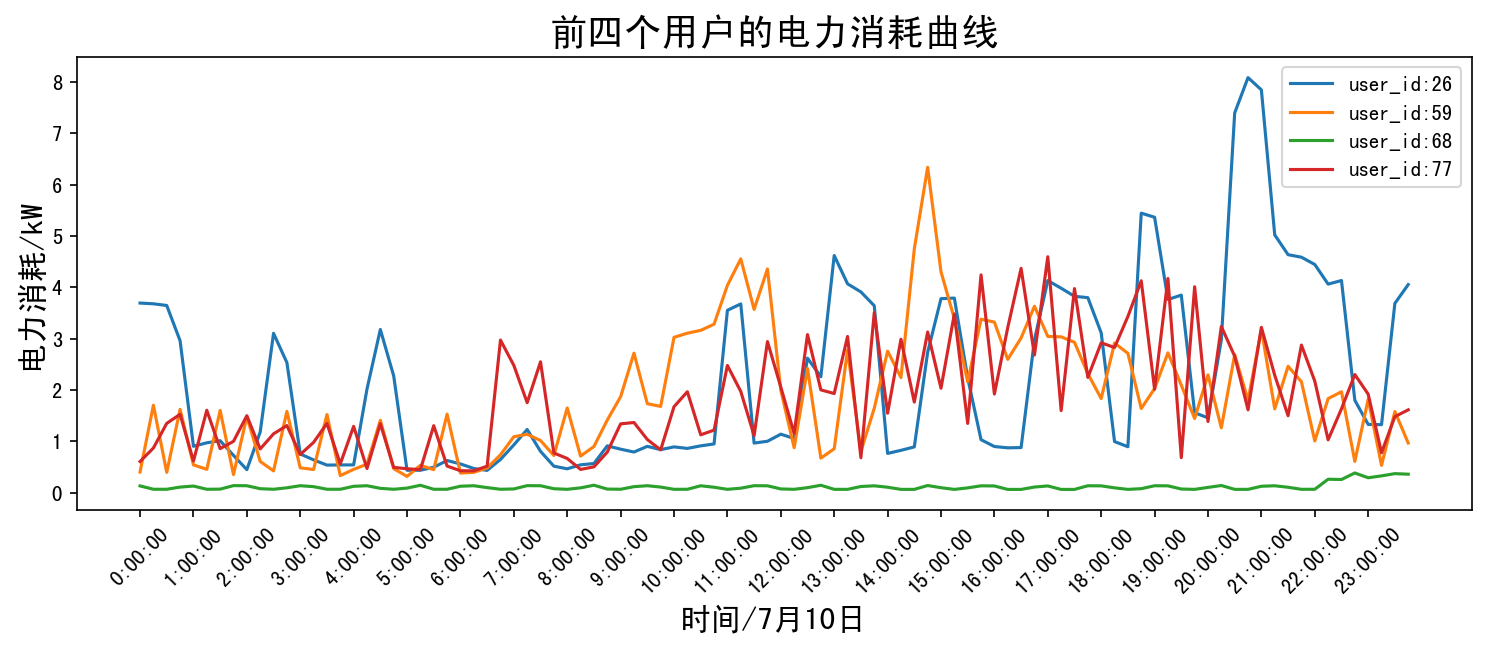

In [15]:
# 选择4个用户查看负荷曲线
fig = plt.figure(figsize=(12, 4),dpi=150)
plt.plot(col,data.iloc[0])  
plt.plot(col,data.iloc[1])  
plt.plot(col,data.iloc[2])  
plt.plot(col,data.iloc[3])  
plt.legend(['user_id:26','user_id:59','user_id:68','user_id:77'])
plt.xlabel('时间/7月10日',fontsize=15)
plt.xticks(range(0,96,4),rotation=45,fontsize=10)
plt.ylabel('电力消耗/kW',fontsize=15)
plt.yticks(fontsize=10)
plt.title('前四个用户的电力消耗曲线',fontsize=18)

plt.show()

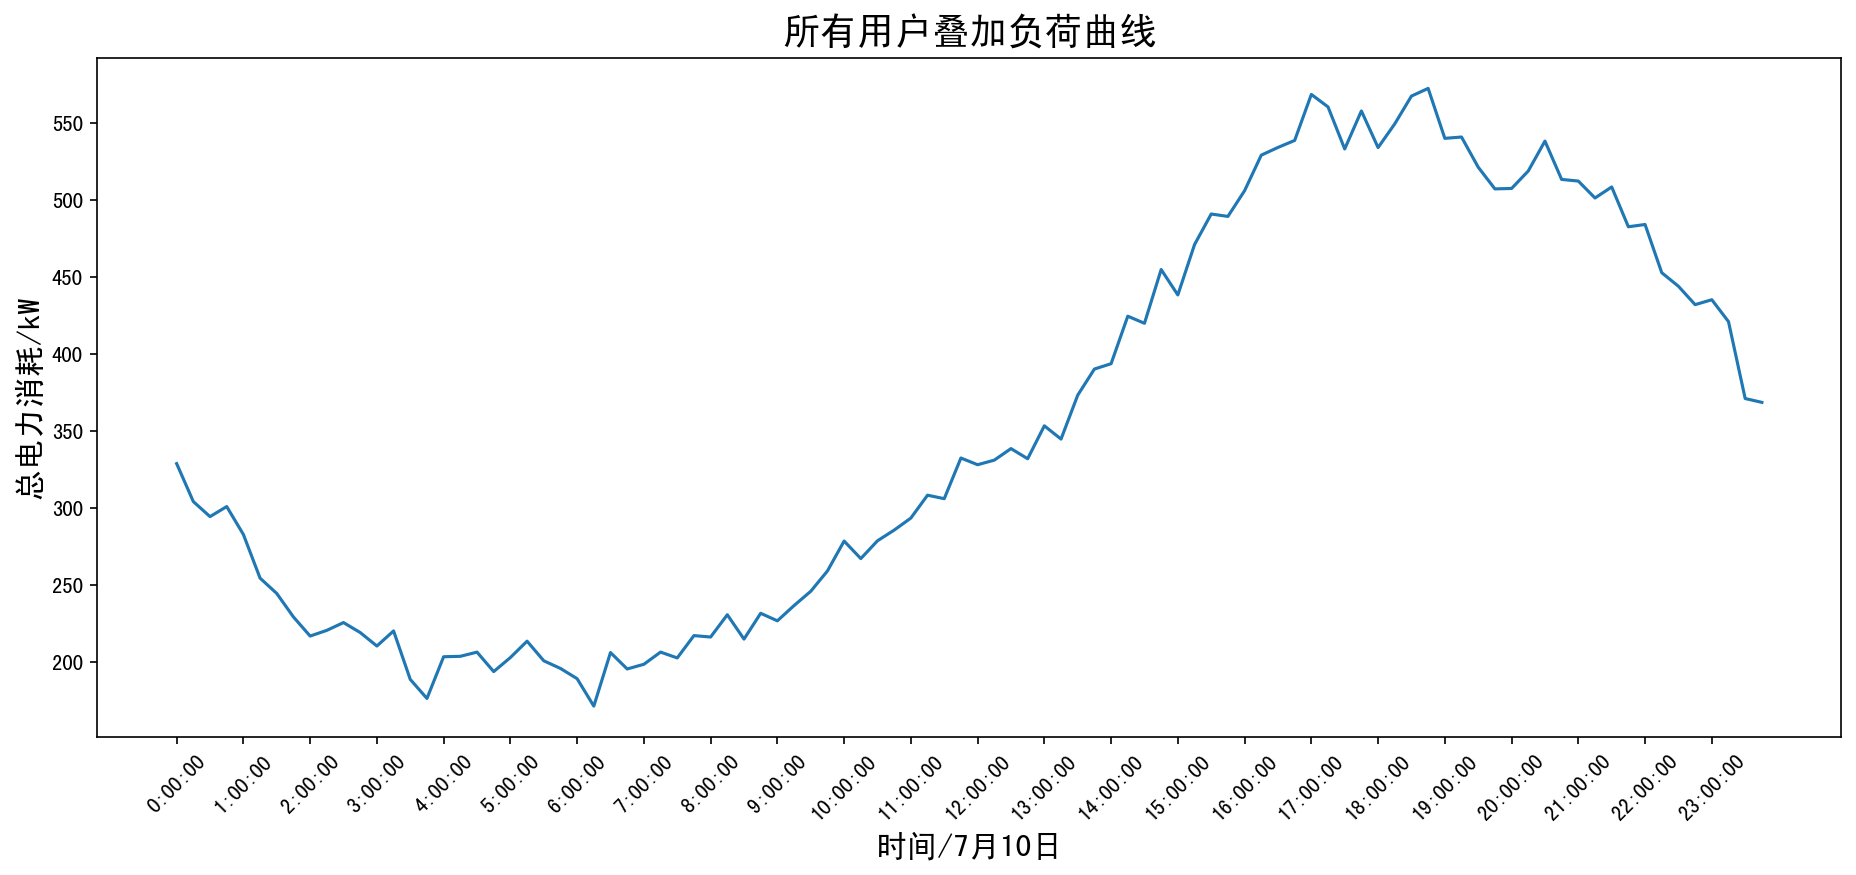

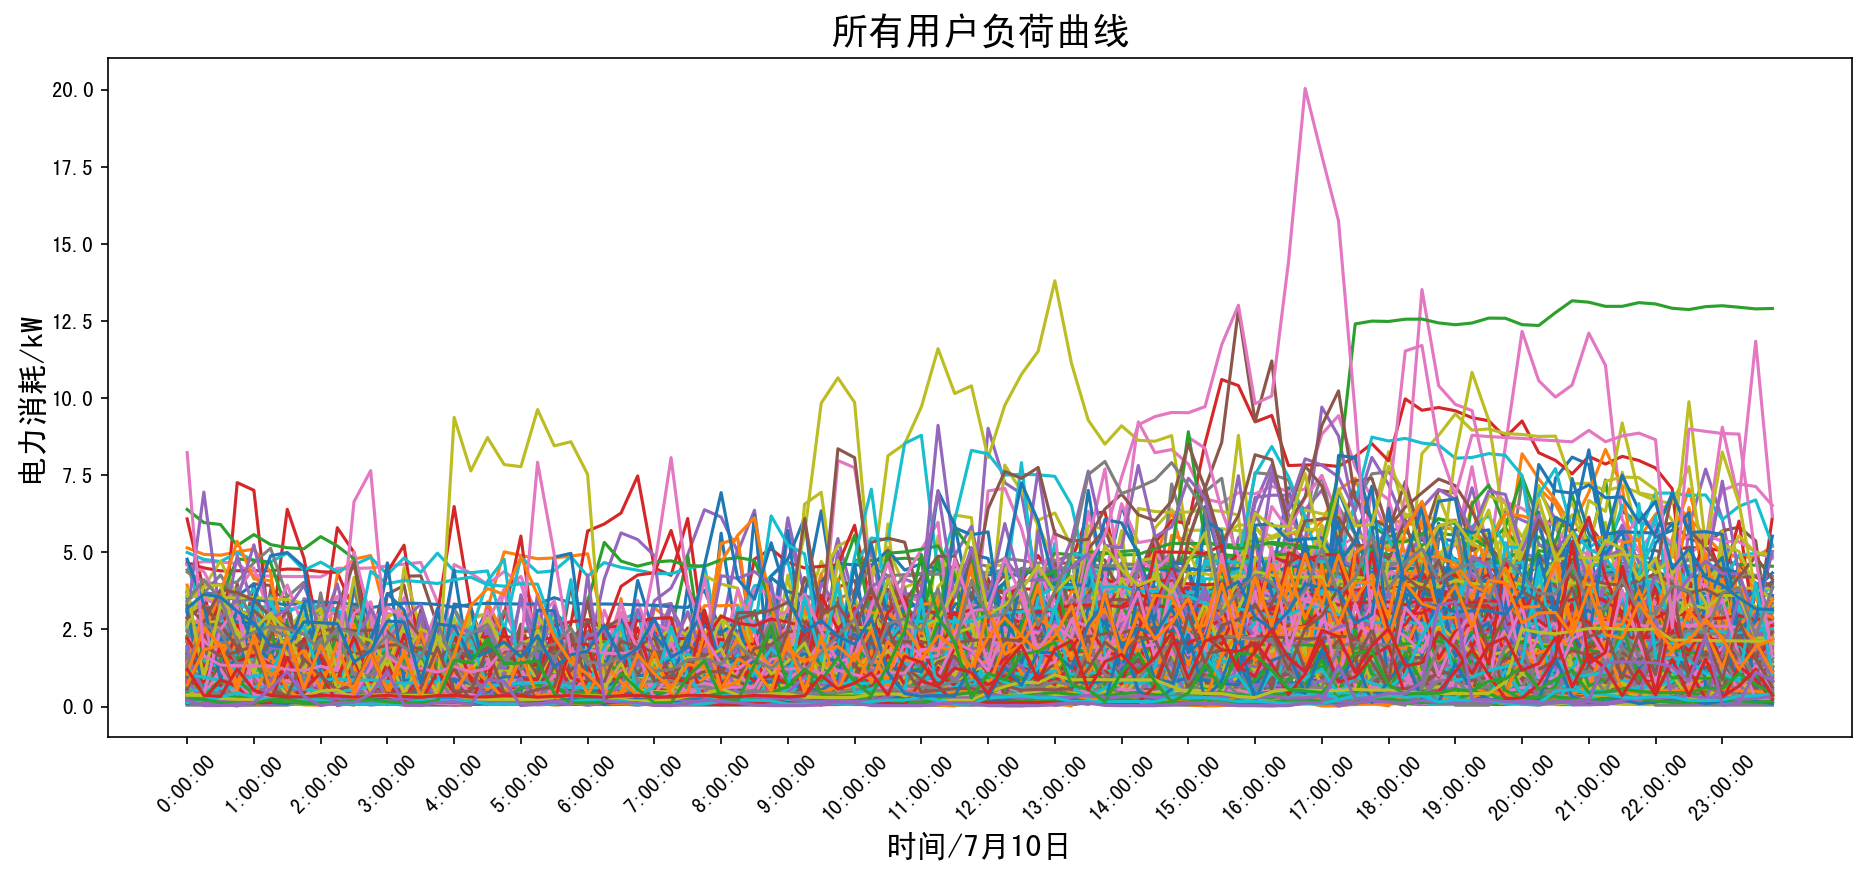

In [16]:
# 所有用户负荷曲线
fig = plt.figure(figsize=(15, 6),dpi=150)

plt.plot(col,data.sum())
plt.xlabel('时间/7月10日',fontsize=15)
plt.xticks(range(0,96,4),rotation=45,fontsize=10)
plt.ylabel('总电力消耗/kW',fontsize=15)
plt.yticks(fontsize=10)
plt.title('所有用户叠加负荷曲线',fontsize=18)
plt.show()

fig = plt.figure(figsize=(15, 6),dpi=150)

plt.plot(col,data.T)
plt.xlabel('时间/7月10日',fontsize=15)
plt.xticks(range(0,96,4),rotation=45,fontsize=10)
plt.ylabel('电力消耗/kW',fontsize=15)
plt.yticks(fontsize=10)
plt.title('所有用户负荷曲线',fontsize=18)

plt.show()

### 特征工程

这里认为9：00-17：00为峰期，0：00-6：00，21：00-24：00为谷期，6：00-9：00，17：00-21：00为平期

In [17]:
fea_data = pd.DataFrame()
fea_data['最大值'] = data.max(axis=1)
fea_data['最小值'] = data.min(axis=1)
fea_data['平均值'] = data.mean(axis=1)
fea_data['标准差'] = data.std(axis=1)
fea_data['最小负荷率'] = fea_data['最小值']/fea_data['最大值']
fea_data['负荷率'] = fea_data['平均值']/fea_data['最大值']
fea_data['峰谷差率'] = (fea_data['最大值']-fea_data['最小值'])/fea_data['最大值']
fea_data['峰期负载率'] = data.iloc[:,4*9:4*17].mean(axis=1)/fea_data['平均值'] # 峰期平均负载/全天平均负载
fea_data['谷期负载率'] = pd.concat([data.iloc[:,4*0:4*6],data.iloc[:,4*21:4*24]],axis=1).mean(axis=1)/fea_data['平均值'] # 谷期平均负载/全天平均负载
fea_data['平期负载率'] = pd.concat([data.iloc[:,4*6:4*9],data.iloc[:,4*17:4*21]],axis=1).mean(axis=1)/fea_data['平均值'] # 平期平均负载/全天平均负载

In [18]:
fea_data.head()

,最大值,最小值,平均值,标准差,最小负荷率,负荷率,峰谷差率,峰期负载率,谷期负载率,平期负载率
user_id,,,,,,,,,,
26,8.089067,0.433867,2.231623,1.792796,0.053636,0.275881,0.946364,0.857001,1.049206,1.100162
59,6.340800,0.316467,1.853080,1.226219,0.049910,0.292247,0.950090,1.535564,0.590975,0.913816
68,0.383533,0.063000,0.113503,0.066789,0.164262,0.295942,0.835738,0.854544,1.234666,0.864521
77,4.598000,0.424933,1.824160,1.091720,0.092417,0.396729,0.907583,1.186669,0.700867,1.171263
86,9.026600,0.195933,2.385469,1.946104,0.021706,0.264271,0.978294,1.522576,0.530743,1.006101


In [19]:
# 最大最小归一化
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

data_scaler = min_max_scaler.fit_transform(fea_data)
# data_scaler = min_max_scaler.fit_transform(data)
#存储到DataFrame
data_scaler = pd.DataFrame(data_scaler)
data_scaler.columns = fea_data.columns

PCA仅为了查看数据在三维空间的分布，后续聚类仍用fea_data的10维数据

In [20]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=0.85)
scaler_pca = pca.fit_transform(data_scaler)

scaler_pca = pd.DataFrame(scaler_pca)

# scaler_pca.columns = ['特征1','特征2','特征3']

print(pca.components_)
print(pca.explained_variance_ratio_)

[[ 0.36601006  0.43771283  0.56952915  0.4147437   0.11077301  0.31029809
  -0.11077301  0.15856814 -0.1740585   0.04244857]
 [-0.24378679  0.17778222 -0.10678232 -0.27801791  0.53578608  0.40625483
  -0.53578608 -0.09014448  0.20329165 -0.17786263]
 [ 0.14258147  0.08471714  0.1661969   0.17480425 -0.08046063 -0.05228566
   0.08046063 -0.69853796  0.64084054 -0.00144876]
 [ 0.08698987  0.02032407  0.05579092  0.02779137 -0.10965142 -0.08449788
   0.10965142  0.33564065  0.28536556 -0.87341846]]
[0.33367363 0.28670577 0.19525394 0.1045456 ]


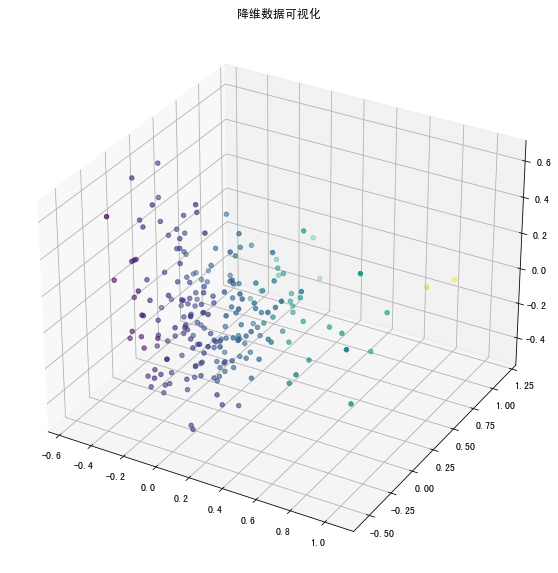

In [21]:
fig = plt.figure(figsize=(10,10))
#创建绘图区域
ax = plt.axes(projection='3d')
#构建xyz
x = scaler_pca.iloc[:,0]
y = scaler_pca.iloc[:,1]
z = scaler_pca.iloc[:,2]
c = x + y
ax.scatter3D(x, y, z,c=c)
ax.set_title('降维数据可视化')

plt.show()

#### 聚类

In [22]:
from sklearn.cluster import KMeans,DBSCAN,SpectralClustering
from sklearn import metrics

In [23]:
print('kmeans调参\n')
for test_k in range(2,10):
    km = KMeans(test_k,random_state=123).fit(data_scaler)
    
    print('k={}'.format(test_k))
    print('Calinski-Harabaz Index:{}'.format(metrics.calinski_harabasz_score(data_scaler, km.labels_)))# 方差比标准，越大越好
    print('轮廓系数:{}'.format(metrics.silhouette_score(data_scaler, km.labels_, metric='euclidean')))# 轮廓系数[-1,1]，越大越好
   

kmeans调参

k=2
Calinski-Harabaz Index:53.531531208223
轮廓系数:0.18732648910741356
k=3
Calinski-Harabaz Index:56.66642280851413
轮廓系数:0.20656410164487596
k=4
Calinski-Harabaz Index:60.444486745813556
轮廓系数:0.21974437241673128
k=5
Calinski-Harabaz Index:56.213944662270606
轮廓系数:0.18947096306941788
k=6
Calinski-Harabaz Index:53.03526574681714
轮廓系数:0.1891402858703722
k=7
Calinski-Harabaz Index:52.06001353740209
轮廓系数:0.1998870750309895
k=8
Calinski-Harabaz Index:50.87668163079086
轮廓系数:0.2128760766102981
k=9
Calinski-Harabaz Index:49.82222498545859
轮廓系数:0.20327564952737762


In [24]:
# 谱聚类
for n in range(2,10):
        SC = SpectralClustering(n_clusters=n,assign_labels="discretize",random_state=0).fit(data_scaler)

        print('n:{}'.format(n))
        print('Calinski-Harabaz Index:{}'.format(metrics.calinski_harabasz_score(data_scaler, SC.labels_)))# 方差比标准，越大越好
        print('轮廓系数:{}'.format(metrics.silhouette_score(data_scaler, SC.labels_, metric='euclidean')))# 轮廓系数[-1,1]，越大越好



n:2
Calinski-Harabaz Index:53.52278410757709
轮廓系数:0.1874345786421971
n:3
Calinski-Harabaz Index:55.10814651865903
轮廓系数:0.2004405857432277
n:4
Calinski-Harabaz Index:57.88108811417533
轮廓系数:0.20923827541332846
n:5
Calinski-Harabaz Index:51.93530398482355
轮廓系数:0.18518748126913384
n:6
Calinski-Harabaz Index:46.7539556278151
轮廓系数:0.15438138707610133
n:7
Calinski-Harabaz Index:44.74522842760383
轮廓系数:0.15583940611961417
n:8
Calinski-Harabaz Index:44.450004138266216
轮廓系数:0.1878650404714958
n:9
Calinski-Harabaz Index:41.21646717663079
轮廓系数:0.16140112689215896


综合k-means聚类和谱聚类可以得知,类数=4时，聚类效果最好

In [25]:
def K_m_analyse(n):

    n_clusters = n
    km = KMeans(n_clusters,random_state=123).fit(data_scaler)


    print('结果标签：\n{}'.format(km.labels_))
    print('最终每个类别的数目为：\n',pd.Series(km.labels_).value_counts())

    cluster_center = pd.DataFrame(km.cluster_centers_,columns = data_scaler.columns) # 将聚类中心放在数据框中
    cluster_center.index = pd.DataFrame(km.labels_ ).drop_duplicates().iloc[:,0]      # 将样本类别作为数据框索引    

    print('\n聚类中心：\n{}'.format(cluster_center))

    print('\n评估指标：')
    print('Calinski-Harabaz Index:{}'.format(metrics.calinski_harabasz_score(data_scaler, km.labels_)))# 方差比标准，越大越好
    print('轮廓系数:{}'.format(metrics.silhouette_score(data_scaler, km.labels_, metric='euclidean')))# 轮廓系数[-1,1]，越大越好

    # 添加标签


    data['label'] = km.labels_
    data_scaler['label'] = km.labels_


    
    

    
    

In [26]:
K_m_analyse(4)

结果标签：
[1 0 3 0 0 3 3 0 0 0 0 0 3 0 1 3 1 0 1 0 3 3 0 1 3 1 3 0 2 0 0 1 0 2 1 2 3
 1 2 3 3 0 0 1 0 0 3 0 0 3 0 3 0 0 0 0 2 3 0 1 3 3 3 0 1 0 1 2 3 0 0 2 1 3
 0 3 0 3 1 3 3 3 0 2 0 0 1 0 0 1 0 1 1 2 3 1 0 2 3 3 0 3 3 0 0 3 1 0 0 3 2
 1 0 1 0 3 3 1 1 1 3 0 0 3 3 0 0 0 1 0 0 3 0 1 0 3 0 0 0 0 0 0 0 0 0 0 0 0
 1 2 3 0 3 0 0 0 2 0 0 1 1 2 1 0 2 1 0 3 0 0 0 1 3 1 1 1 3 0 0 3 1 0 0 0 0
 0 0 3 3 0 1 0 3 1 0 2 0 2 1 3 0 0 3 3 2 0 1 1 3 3 1 0 0 0 3]
最终每个类别的数目为：
 0    98
3    55
1    44
2    18
dtype: int64

聚类中心：
        最大值       最小值       平均值       标准差     最小负荷率       负荷率      峰谷差率  \
0                                                                         
1  0.222655  0.118572  0.219168  0.244569  0.107283  0.372125  0.892717   
0  0.410423  0.349457  0.507910  0.454996  0.181846  0.498187  0.818154   
3  0.119264  0.324063  0.203275  0.097998  0.586811  0.676287  0.413189   
2  0.157355  0.106134  0.137073  0.167461  0.154683  0.329420  0.845317   

      峰期负载率     谷期负载率     平期负载率  
0      

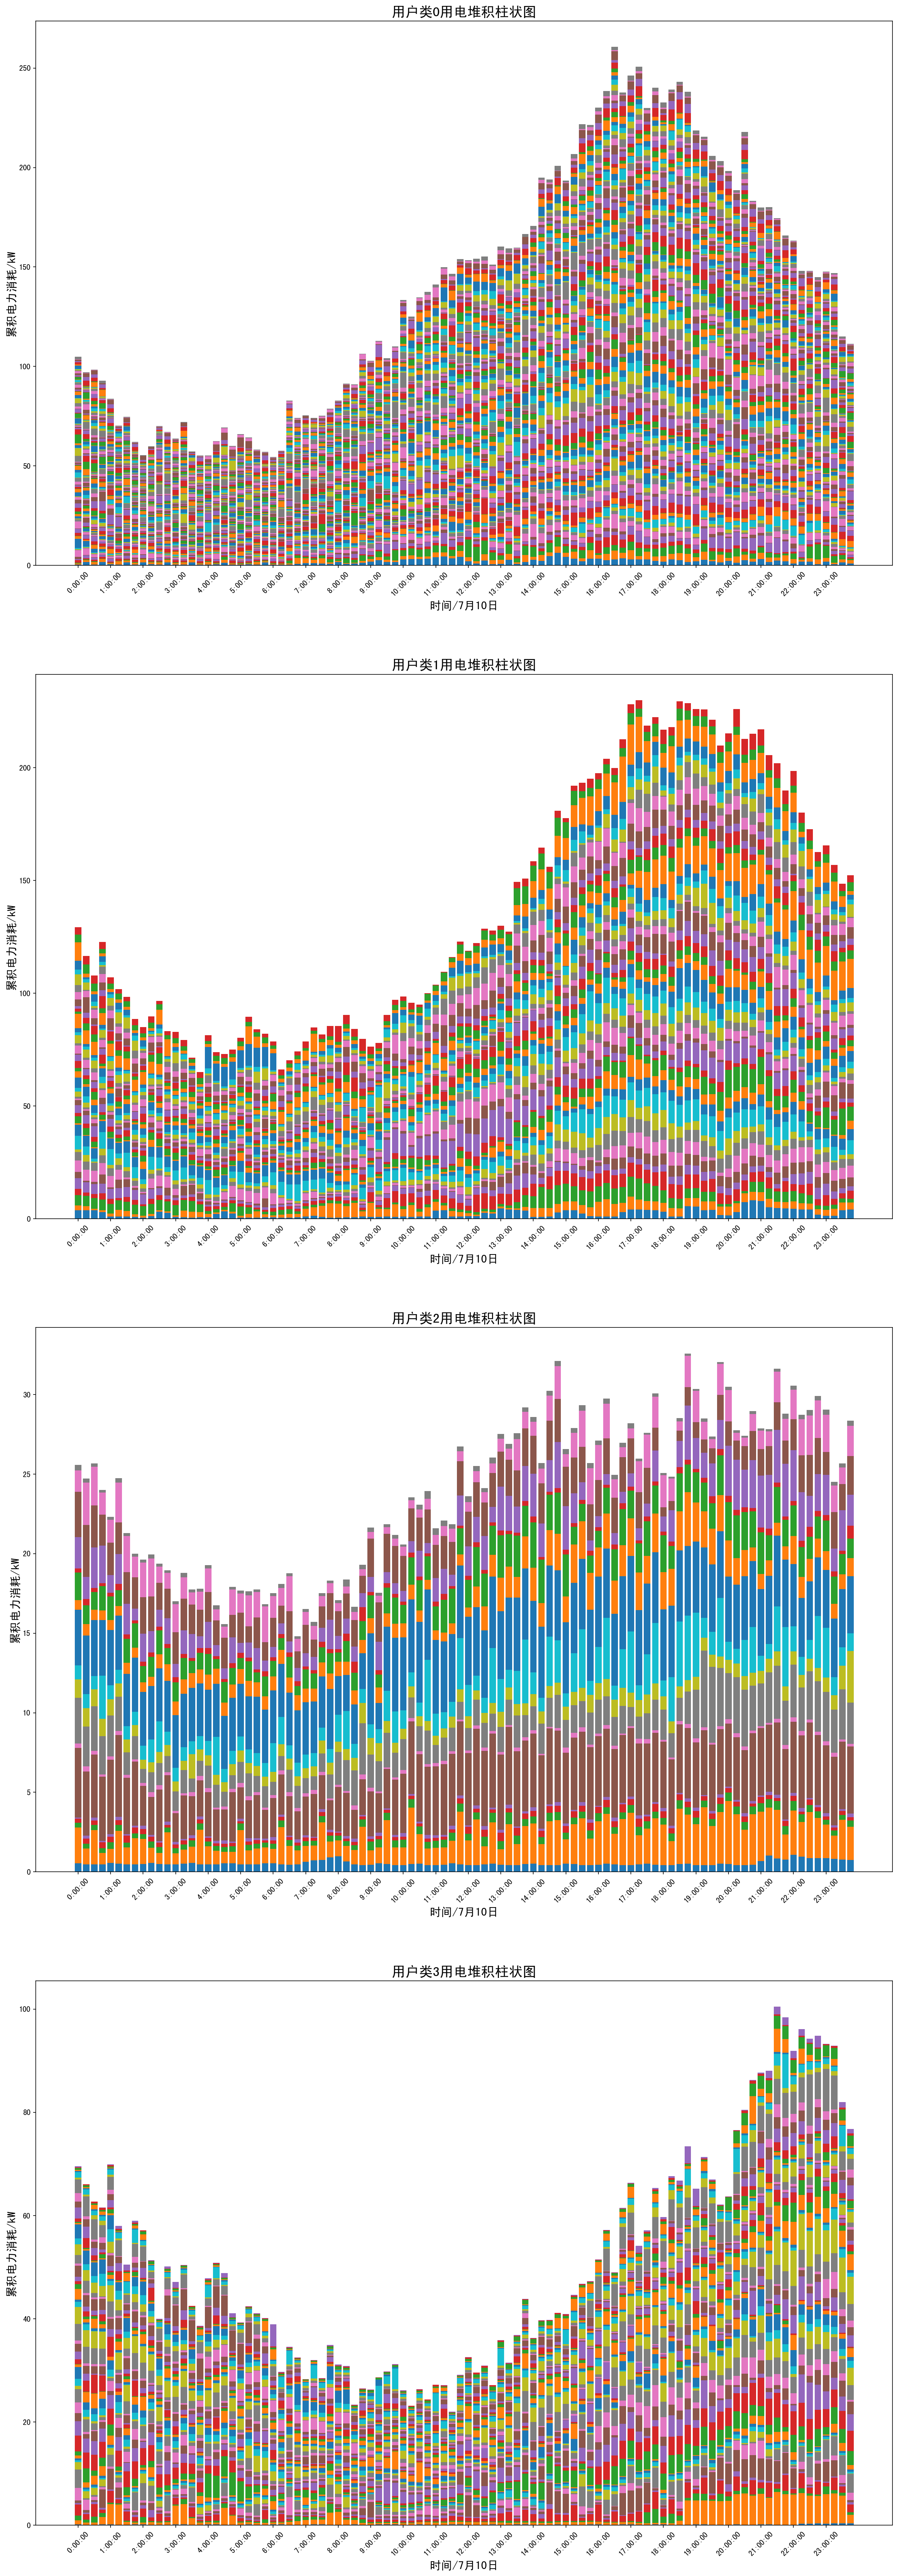

In [27]:
fig = plt.figure(figsize=(20,60),dpi=150)
for i in range(4):
    
    plt.subplot(4,1,i+1)
    data0 = data.loc[data['label'] == i].iloc[:,0:-1]
    
    for j in range(data0.shape[0]):
        data1 = data0.iloc[j,:].values
        if j ==0:
            plt.bar(col,data1)
        else:
            plt.bar(col,data1,bottom=data0.iloc[0:j,:].sum())
        plt.xlabel('时间/7月10日',fontsize=15)
        plt.xticks(range(0,96,4),rotation=45,fontsize=10)
        plt.ylabel('累积电力消耗/kW',fontsize=15)
        plt.yticks(fontsize=10)
        plt.title('用户类%i用电堆积柱状图'%i,fontsize=18)
plt.show()

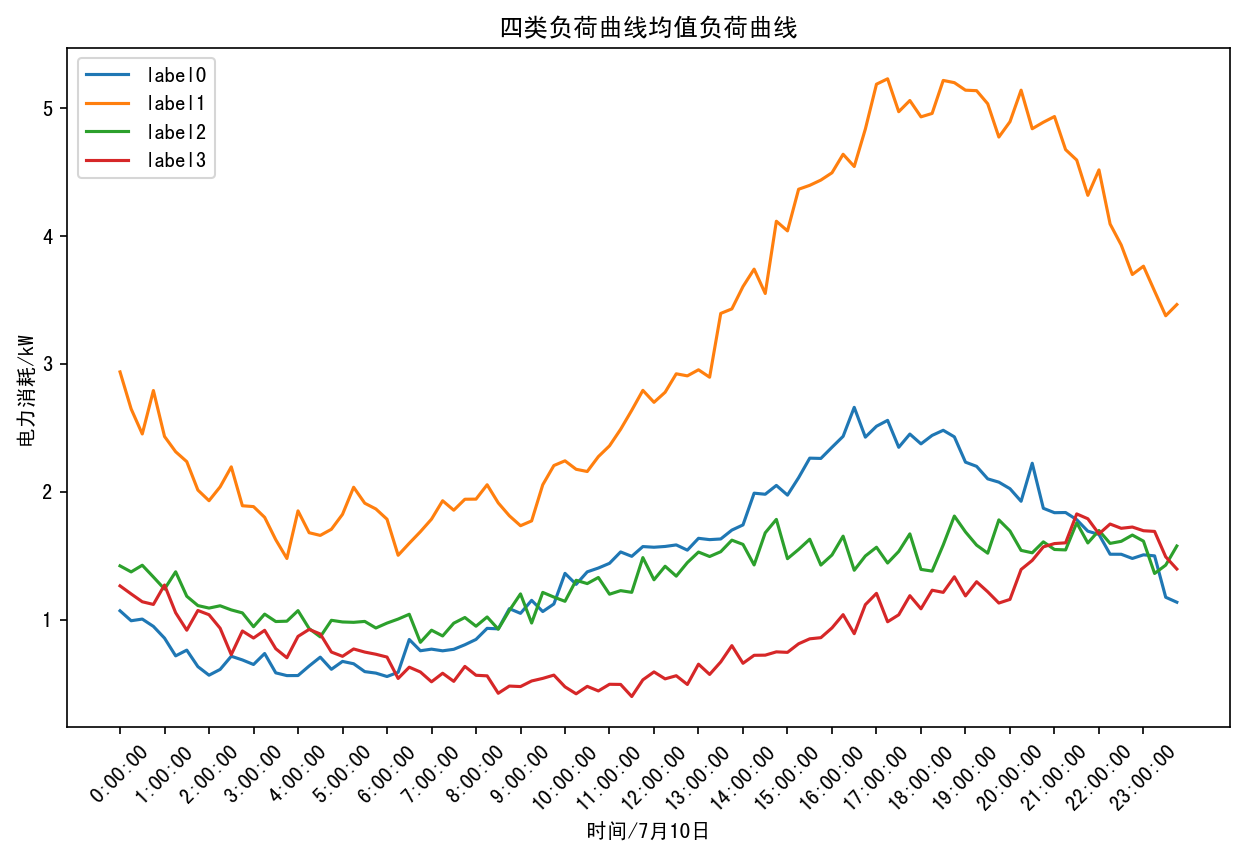

In [28]:
fig = plt.figure(figsize=(10,6),dpi=150)
for i in range(4):
    data0 = data.loc[data['label'] == i].iloc[:,0:-1]

    plt.plot(col,data0.mean())
plt.legend(['label0','label1','label2','label3'])
plt.xlabel('时间/7月10日')
plt.xticks(range(0,96,4),rotation=45,fontsize=10)
plt.ylabel('电力消耗/kW')
plt.yticks(fontsize=10)
plt.title('四类负荷曲线均值负荷曲线')
plt.show()

label0:从均值负荷曲线可以分析，该类用户属于经济状况较好的家庭用电；  
label1:从均值负荷曲线可以分析，该类用户属于小工业生产用电；  
label2:从均值负荷曲线可以分析，该类用户属于经济状况一般的家庭用电；  
label3:从均值负荷曲线可以分析，该类用户属于类似仅照明用电；

### 分类

In [29]:
# 训练数据
train = data_scaler.iloc[0:210,0:-1]
target = data_scaler.iloc[0:210,-1]

# 预测数据
predict_data = data_scaler.iloc[210:,0:-1]

In [30]:
from sklearn.model_selection import train_test_split

# 切分数据
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3, random_state=0)


#### SMOTETomek 综合抽样

In [31]:
from imblearn.combine import SMOTETomek
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

print('不经过任何采样处理的原始 y_train 中的分类情况：{}'.format(Counter(y_train)))


ros = RandomOverSampler(random_state=0, sampling_strategy='auto') 
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
print('随机过采样后，训练集 y_train_ros 中的分类情况：{}'.format(Counter(y_train_ros)))

from imblearn.over_sampling import SMOTE
sos = SMOTE(random_state=0)
X_train_sos, y_train_sos = sos.fit_resample(X_train, y_train)
print('SMOTE过采样后，训练集 y_sos 中的分类情况：{}'.format(Counter(y_train_sos)))

kos = SMOTETomek(random_state=0)  # 综合采样
X_train_kos, y_train_kos = kos.fit_resample(X_train, y_train)
print('综合采样后，训练集 y_kos 中的分类情况：{}'.format(Counter(y_train_kos)))


不经过任何采样处理的原始 y_train 中的分类情况：Counter({0: 63, 3: 39, 1: 33, 2: 12})
随机过采样后，训练集 y_train_ros 中的分类情况：Counter({3: 63, 0: 63, 2: 63, 1: 63})
SMOTE过采样后，训练集 y_sos 中的分类情况：Counter({3: 63, 0: 63, 2: 63, 1: 63})
综合采样后，训练集 y_kos 中的分类情况：Counter({2: 63, 0: 62, 1: 62, 3: 61})


In [32]:
# 随机森林分类
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, min_samples_split=12, random_state=1, n_jobs=-1)

clf = clf.fit(X_train, y_train)

print('Accuracy_score：{}'.format(clf.score(X_test, y_test)))

clf = clf.fit(X_train_ros, y_train_ros)

print('Accuracy_score：{}'.format(clf.score(X_test, y_test)))

clf = clf.fit(X_train_sos, y_train_sos)

print('Accuracy_score：{}'.format(clf.score(X_test, y_test)))


clf = clf.fit(X_train_kos, y_train_kos)

print('Accuracy_score：{}'.format(clf.score(X_test, y_test)))

Accuracy_score：0.8253968253968254
Accuracy_score：0.8253968253968254
Accuracy_score：0.8253968253968254
Accuracy_score：0.8571428571428571


In [33]:
# GaussianNB
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(train, target,test_size=0.3, random_state=0)

clf = GaussianNB()

clf = clf.fit(X_train, y_train)

print('Accuracy_score：{}'.format(clf.score(X_test, y_test)))

clf = clf.fit(X_train_ros, y_train_ros)

print('Accuracy_score：{}'.format(clf.score(X_test, y_test)))

clf = clf.fit(X_train_sos, y_train_sos)

print('Accuracy_score：{}'.format(clf.score(X_test, y_test)))


clf = clf.fit(X_train_kos, y_train_kos)

print('Accuracy_score：{}'.format(clf.score(X_test, y_test)))

Accuracy_score：0.9682539682539683
Accuracy_score：0.9206349206349206
Accuracy_score：0.9047619047619048
Accuracy_score：0.9047619047619048


In [34]:
from sklearn.ensemble import BaggingClassifier


X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3, random_state=0)

clf = BaggingClassifier(RandomForestClassifier(),  # n_estimators=100, max_depth=2, min_samples_split=12, random_state=0, n_jobs=-1),
                        n_estimators=100,
                        max_samples=100,
                        bootstrap=True,
                        n_jobs=-1,
                        oob_score=True)
clf = clf.fit(X_train, y_train)
print('Accuracy_score：{}'.format(clf.score(X_test, y_test)))

clf = clf.fit(X_train_ros, y_train_ros)

print('Accuracy_score：{}'.format(clf.score(X_test, y_test)))

clf = clf.fit(X_train_sos, y_train_sos)

print('Accuracy_score：{}'.format(clf.score(X_test, y_test)))


clf = clf.fit(X_train_kos, y_train_kos)

print('Accuracy_score：{}'.format(clf.score(X_test, y_test)))

Accuracy_score：0.9365079365079365
Accuracy_score：0.8888888888888888
Accuracy_score：0.873015873015873
Accuracy_score：0.8888888888888888


对比上述三个模型，选择RandomForestClassifier()

### 参数优化

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

0.9639183673469388 31


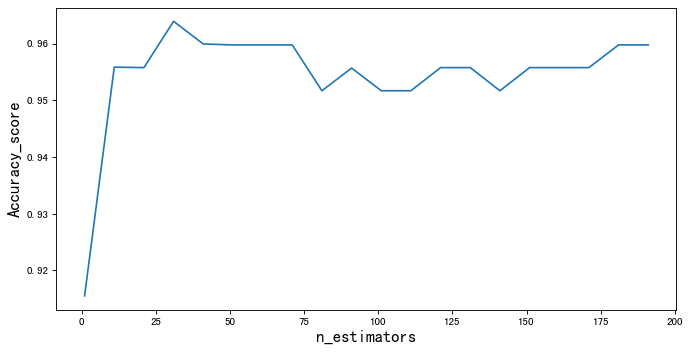

In [36]:
# 调整n_estimators
scorel = []
for i in range(0,200,10):
    clf_rf = RandomForestClassifier(n_estimators=i+1,
                                 n_jobs=-1,
                                 random_state=0)
    score = cross_val_score(clf_rf,X_train_kos,y_train_kos,cv=5).mean()
    scorel.append(score)

print(max(scorel),(scorel.index(max(scorel))*10)+1)
fig = plt.figure(figsize=(10,5),dpi=80)
plt.plot(range(1,201,10),scorel)
plt.xlabel('n_estimators',fontsize=15)
plt.ylabel('Accuracy_score',fontsize=15)
plt.show()

0.9679183673469387 33


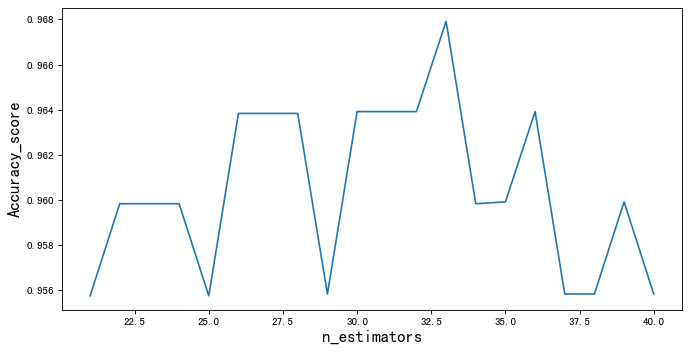

In [37]:
# 细化n_estimators
scorel = []
for i in range(21,41):
    clf_rf = RandomForestClassifier(n_estimators=i,
                                 n_jobs=-1,
                                 random_state=0)
    score = cross_val_score(clf_rf,X_train_kos,y_train_kos,cv=5).mean()
    scorel.append(score)

print(max(scorel),(scorel.index(max(scorel)))+21)
fig = plt.figure(figsize=(10,5),dpi=80)
plt.plot(range(21,41),scorel)
plt.xlabel('n_estimators',fontsize=15)
plt.ylabel('Accuracy_score',fontsize=15)
plt.show()

最佳超参数n_estimators=33

In [38]:
clf_R = RandomForestClassifier(n_estimators=33,random_state=0)

param_grid = {
    'max_depth':np.arange(1, 20, 1),
    'min_samples_split':np.arange(1, 10, 1),
    'max_features':np.arange(1,5,1)
             }                               

grid = GridSearchCV(clf_R,
    param_grid=param_grid,
    cv=5, scoring="accuracy", verbose=0, n_jobs=-1) # accuracy作为评估指标
grid.fit(X_train_kos, y_train_kos)
print(grid.best_score_)
print(grid.best_params_)

0.9679183673469387
{'max_depth': 8, 'max_features': 3, 'min_samples_split': 2}


最佳超参数：max_depth': 8, 'max_features': 3, 'min_samples_split': 2

### 评估验证

In [39]:
from sklearn import metrics
from sklearn.model_selection import ShuffleSplit

In [40]:
train_kos = pd.concat([X_train_kos,X_test],ignore_index=True)
target_kos = pd.concat([y_train_kos,y_test],ignore_index=True)

In [41]:
clf = RandomForestClassifier(n_estimators=33,max_depth=8,max_features=3,min_samples_split=2,random_state=0)

# 五折交叉验证
scores = cross_val_score(clf, train_kos, target_kos, cv=5)
print(scores)
print("Accuracy_score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# 随机排列交叉验证
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=1)
scores = cross_val_score(clf, train_kos, target_kos, cv=cv)
print(scores)
print('Accuracy_score：{}'.format(scores.mean(), scores.std() * 2))

# F1验证
scores = cross_val_score(clf, train_kos, target_kos, cv=5, scoring='f1_macro')
print(scores) 
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.98412698 0.9516129  0.98387097 0.98387097 0.91935484]
Accuracy_score: 0.96 (+/- 0.05)
[0.94680851 0.94680851 0.95744681 0.93617021 0.95744681]
Accuracy_score：0.948936170212766
[0.98331479 0.95174358 0.98462255 0.98462255 0.92234492]
F1: 0.97 (+/- 0.05)


### 输出模型参数

In [42]:
import joblib

In [43]:
# 保存模型参数
clf = RandomForestClassifier(n_estimators=33,max_depth=8,max_features=3,min_samples_split=2,random_state=0)
clf.fit(X_train_kos,y_train_kos)

joblib.dump(clf,"Model/企业电力营销模型.pkl")

['Model/企业电力营销模型.pkl']

### 加载模型并进行预测

In [44]:
# 预测数据
predict_data

,最大值,最小值,平均值,标准差,最小负荷率,负荷率,峰谷差率,峰期负载率,谷期负载率,平期负载率
210,0.384366,0.154774,0.486617,0.373383,0.074214,0.485456,0.925786,0.311538,0.500152,0.574701
211,0.232704,0.170801,0.348692,0.250813,0.144384,0.588834,0.855616,0.518045,0.405033,0.436146
212,0.237074,0.059681,0.124496,0.164898,0.043692,0.167693,0.956308,0.757717,0.236273,0.361332
213,0.115810,0.166374,0.145632,0.150315,0.283480,0.491830,0.716520,0.671112,0.213164,0.512261
214,0.203510,0.007670,0.047704,0.156442,0.000000,0.046533,1.000000,0.000000,0.664697,0.752715


In [45]:
clf = joblib.load('Model/企业电力营销模型.pkl')
clf.predict(predict_data) #预测结果标签

array([1, 0, 0, 0, 3], dtype=int32)